In [1]:
from tectosaur2.nb_config import setup

setup()

# Computing boundary integrals with quadrature by expansion (QBX).

## Summary

* I'll introduce the basic nearfield evaluation problem that lies at the core of discretizing boundary integral equations.
* Then, I'll introduce QBX as a solution for this problem and explain a particular form of QBX.
* We'll implement a very basic single-expansion QBX integrator. 
* Then, we'll use `tectosaur2.integrate_term` in order to generically computing boundary integrals using QBX. 
* We'll look at error rates and show that QBX is accurate almost to machine precision.


## Near-field evaluation for boundary integrals

Suppose that we're modeling a fault as a infinitesimally thin surface. And there's some slip on that surface. And we want to calculate how much displacement that slip has caused near the fault. A common approach is to use [triangular or rectangular dislocation elements](../tdes/part1_sa_tdes)  but that would limit us to constant slip per element, which leads to stress singularities and unhappiness. So, let's back off to a fully general mathematical description. This type of surface integral is at the core of a boundary integral method:

\begin{equation}
u(\mathbf{p}) = \int_{S} K(\mathbf{p}, \mathbf{q}) \phi(\mathbf{q}) d\mathbf{q}
\end{equation}

where $K(\mathbf{p}, \mathbf{q})$ is normally a fundamental solution to a PDE or the derivative thereof. 

At a basic level, these integrals are hard because $K$ is **singular**. Depending on the dimension (2D or 3D) and the particular problem, the singularity will be something like $\log(r)$ or $r^{-n}$ where $r = \|\mathbf{p}-\mathbf{q}\|_2$.

If $\mathbf{p}$ is far away from $S$, then the integral is very smooth and well-behaved and can be super easily computed with standard quadrature rules like Gaussian quadrature or the trapezoidal rule. But, if $\mathbf{p}$ is close to some part of $S$, then the singularity in $K(\mathbf{p},\mathbf{q})$ makes computation of the integral hard. In the boundary integral literature, this is called the **near-field evaluation problem**. Or in the case where $\mathbf{p} \in S$, the **singular evaluation problem**.

The brute force solution to the problem is to just compute the integral with a very high order quadrature rule or an adaptive quadrature rule. For the near-field case, using a higher order quadrature order will eventually converge to the correct value but the number of quadrature points will grow prohibitively large as $\mathbf{p}$ approaches $S$. However, for the singular evaluation problem, some integrals will not converge at all. Many approaches have been developed to handle these singular and near-singular integrals (CITE a few?).

## What is QBX?

A robust and general solution to nearfield evaluation is a method called quadrature by expansion (**QBX**). The exciting thing about QBX is that we can indirectly compute our boundary integral for observation points ($p$) that are very close to or even directly on the boundary while only *directly* evaluating the integrals for points that are far from the boundary. The basic idea is to form an approximation for $u(\mathbf{p})$ "centered" at a point $\mathbf{c}$ away from $S$ and then use that proxy to extrapolate to points that are close to $S$. There are several versions of QBX depending on the type of proxy used:

* The [original QBX paper](https://arxiv.org/abs/1207.4461){cite:p}`klocknerQuadratureExpansionNew2013` uses a separation of variables technique for the Helmholtz equation to form a series expansion in terms of Hankel functions and Bessel functions. This works for other PDEs if some separation of variables techniques are known. With Poisson and elasticity, we use a complex variable formulation in 2D and spherical harmonic expansions in 3D.
* The [quadrature by kernel-independent expansion (QBKIX) paper](https://arxiv.org/abs/1612.00977){cite:p}`rahimianUbiquitousEvaluationLayer2018` forms a proxy set of point sources which replace the original integral locally arounding the expansion point $c$. This approach is "kernel-independent" since it will work well for most functions $K(\mathbf{p}, \mathbf{q})$ even if the functions are complex enough that analytical techniques like separation of variables are too difficult.
* The [GIGAQBX algorithm](https://arxiv.org/pdf/1805.06106.pdf){cite:p}`walaFastAlgorithmQuadrature2019` derives rigorous error and runtime bounds for QBX combined with the fast multipole method when the same expansion centers are used for both the near and far-field.

There are several other approaches. All share the share basic ideas but differ in design decisions like whether to apply QBX to only the near-field integrals ("local" QBX) or apply QBX to all the integrals ("global" QBX).

Ultimately, QBX works because even though the surface integral may be singular, $u(\mathbf{p})$ is normally a smooth function. Approximating $u(p)$ directly provides a sort of backdoor around the singularities in $K(\mathbf{p},\mathbf{q})$. And, QBX methods are generally efficient because $c$ is far enough away from $S$ that the computation of the expansion is fairly cheap.

## QBX via complex power series

Here, I'll focus specifically on a version of [QBX introduced here in section 5.3](https://arxiv.org/abs/1610.00823){cite:p}`askhamAdaptiveFastMultipole2017` that expands the solution in terms of a complex power series and works well for the Poisson equation and for elasticity in two dimensions. 

```{margin}
Even though this particular form of expansion is less popular than others, I think it's a nice introduction to QBX because the method is somewhat independent of the kernel and can be implemented and explained entirely in terms of the off-surface potential values. For a straight-forward introduction to more standard expansion methods for the 2D Laplace equations, I would recommend section 2.4 of {cite:t}`afklintebergAdaptiveQuadratureExpansion2018`
```

First, I'll define some terminology that we'll use a lot through all the sections on boundary integral equations:
* observation point: this is the point $x$ where we'd like to evaluate $u(x)$. 
* source surface: this is the surface $S$.
* the expansion center, $c$ and the expansion radius, $r$. The expansion radius is the maximum distance from $c$ where the expansion is valid.

To expand, we re-write the observation point into the complex plane. The observation point becomes $\hat{p} = p_x + ip_y$ and the expansion center becomes $\hat{c} = c_x + ic_y$. The expansion center is a distance $r$ from $S$.

\begin{equation}
u(x) = Re\big(\sum_{l=0}^{p} \alpha_l(\hat{p} - \hat{c})^l\big)
\end{equation}

Then, the expansion coefficients ($\alpha$) are computed by computing a clever integral of $u(\mathbf{p})$ around a circle with radius $\delta r$ centered at $\mathbf{c}$. For $l > 0$, the integral we compute is:

\begin{equation}
\alpha_l = \frac{1}{\pi (\delta r)^l}\int_{0}^{2\pi} u(\mathbf{c} + \delta r(cos \theta, sin \theta)) e^{-il\theta} d\theta
\end{equation}
and for $l=0$, we simply divide the above integral by two. The values of $u$ will be computed "directly" by just using a simple quadrature rule on the original surface integral. We'll normally use Gaussian quadrature, but in the first example below, we'll actually use the trapezoidal rule because the trapezoidal rule is extremely accurate and efficient for periodic integrands.

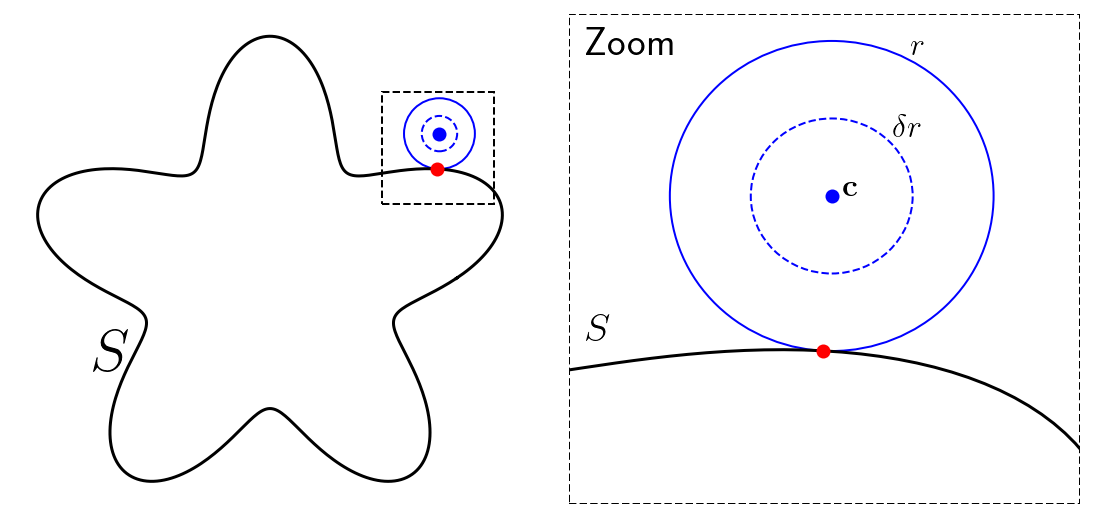

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
theta = np.linspace(0, 2 * np.pi, 500)
xsS = np.cos(theta) * (1.0 + 0.3 * np.sin(theta * 5))
ysS = np.sin(theta) * (1.0 + 0.3 * np.sin(theta * 5))

t = theta
dxdt = np.sin(t) * (-0.3 * np.sin(5 * t) - 1) + 1.5 * np.cos(t) * np.cos(5 * t)
dydt = np.cos(t) + 1.5 * np.cos(5 * t) * np.sin(t) + 0.3 * np.cos(t) * np.sin(5 * t)
ddt_norm = np.sqrt(dxdt ** 2 + dydt ** 2)
dxdt /= ddt_norm
dydt /= ddt_norm
nx = dydt
ny = -dxdt
jacobian = 2 * np.pi * ddt_norm

plt.plot(xsS, ysS, "k-")
plt.text(-0.95, -0.5, "$S$", fontsize=30)
plt.gca().add_patch(
    patches.Rectangle(
        (0.6, 0.4), 0.6, 0.6, edgecolor="k", linestyle="--", facecolor="none"
    )
)
plt.axis("off")

theta_C_idx = 46
theta_C = theta[theta_C_idx]
xsS_C = xsS[theta_C_idx]
ysS_C = ysS[theta_C_idx]

r = 0.19
Cx = xsS_C + r * nx[theta_C_idx]
Cy = ysS_C + r * ny[theta_C_idx]
plt.plot([xsS_C], [ysS_C], "ro")
plt.plot([Cx], [Cy], "bo")
plt.gca().add_patch(plt.Circle((Cx, Cy), r, fill=False, color="b"))
plt.gca().add_patch(
    plt.Circle((Cx, Cy), r * 0.5, fill=False, color="b", linestyle="--")
)

plt.subplot(1, 2, 2)
plt.plot(xsS, ysS, "k-")
plt.gca().add_patch(
    patches.Rectangle(
        (0.6, 0.4), 0.6, 0.6, edgecolor="k", linestyle="--", facecolor="none"
    )
)
plt.text(0.62, 0.95, "Zoom", fontsize=20)
plt.text(0.62, 0.6, "$S$", fontsize=20)
plt.plot([xsS_C], [ysS_C], "ro")
plt.plot([Cx], [Cy], "bo")
plt.gca().add_patch(plt.Circle((Cx, Cy), r, fill=False, color="b"))
plt.gca().add_patch(
    plt.Circle((Cx, Cy), r * 0.5, fill=False, color="b", linestyle="--")
)
plt.text(1.0, 0.95, "$r$", fontsize=16)
plt.text(0.98, 0.85, "$\delta r$", fontsize=16)
plt.text(Cx + 0.013, Cy, "$\mathbf{c}$", fontsize=16)
plt.xlim([0.6, 1.2])
plt.ylim([0.4, 1.0])
plt.axis("off")

plt.tight_layout()
plt.show()
# circle = plt.Circle((0,0), node.radius, fill=False, color='b' if node.is_leaf else 'k')
# plt.gca().add_patch(circle)

### Summary

So, what's the full algorithm look like?

1. Choose an expansion center a distance of $r$ away from the surface.
2. Discretize the integrals for the expansion coefficients and identify the points where we will need to evaluate $u(\mathbf{c} + \delta r(cos \theta, sin \theta))$.
3. Evaluate $u(\mathbf{p})$ for those points by directly evaluating $\int K(\mathbf{p}, \mathbf{q}) \phi(\mathbf{q}) d\mathbf{q}$ using a simple quadrature rule (e.g. Gaussian quadrature). Because we choose, $\delta = 1/2$, the closest we will have to evaluate $u(\mathbf{p})$ is $r/2$.
4. Integrate (sum) to compute $\alpha_l$.
5. Now that we have the coefficients $\alpha_l$, to evaluate $u(\mathbf{p})$ at any point arbitrarily close to the surface, simply evaluate the complex power series and take the real part.

Some comments about QBX:
* Because the evaluation of the series is independent of the computation of the coefficients, we can compute **many near-field values for the price of one**.
* The method actually works just as well for computing a $u(\mathbf{p})$ directly on the boundary. To be precise, we can compute a limit to the boundary like $\lim_{\mathbf{p} \to S^+}u(\mathbf{p})$. Thus, QBX can actually **replace the singular quadrature required in many boundary integral methods**.
* The method works best when there are no singularities in $u(\mathbf{p})$. The most common violation of this is a sharp corner in $S$. When there are singularities in $u(\mathbf{p})$, QBX will still work, but the expansion center $c$ will need to be closer to the surface and, as a result, a high number of quadrature points will be needed in the vicinity of the corner.
* There are four parameters which all control the accuracy. The location of the expansion center, $c$. The distance to offset from the surface, $r$. The order of the expansion, $p$. And the order of quadrature method used to compute the coefficients of the expansion, $n_q$. They interact in somewhat complex ways.
* Increasing $p$ will improve the accuracy of the expansion up to a point, but eventually the higher order terms in the expansion will become corrupted by the error introduced by the numerical integration. So, in order to increase $p$, $n_q$ must also increase.
* By increasing $r$, the expansion is formed further from the surface and (holding $n_q$ constant) the expansion coefficients will be computed more accurately, but (holding $p$ constant) the accuracy of the expansion near the surface will decrease because the distance from the evaluation point to the expansion center is larger.
* The choices of $r$ and $c$ are closely connected. Since the only value we ultimately care about is $u(\mathbf{p})$, we can choose the exact location and size of the "expansion circle" defined by the expansion center $c$, the expansion radius $r$ and the radius of integration $\delta r$. Let's list the considerations that go into this judgement:
    1. Larger radius is better: Holding the expansion center fixed, a larger expansion radius is beneficial because the expansion can cover more ground so more interior points can be computed by a single expansion. 
    2. Larger radius is better: Holding the expansion center fixed, a larger expansion radius means the values $u(\mathbf{c} + \delta r(cos \theta, sin \theta))$ can be computed more cheaply because the evaluation points are further from the source surface. 
    3. Hard upper limit on expansion radius: Holding the expansion center fixed, too large a radius will cause the expansion circle to intersect the source surface. Expanding requires the underlying $u$ field to be smooth and allowing the expansion circle to intersect the source surface violates that constraint because $u$ is not smooth across $S$.
    4. Closer expansion centers are more accurate: Holding the number of terms in the power series constant, if we increase the distance from the expansion center $c$ to the observation point $x$, we will also increase the error in computing $u(x)$.
    5. Closer expansion centers are more expensive: Remember that we compute the values $u(\mathbf{c} + \delta r(cos \theta, sin \theta))$ directly by performing a direct Gaussian quadrature of the integral. The integrand will be more peaked when the evaluation points are closer to the source surface. More peaked integrands will require a higher quadrature order to be accurate.
    6. The conclusion is that, we should **choose the largest radius that doesn't intersect the source surface**. For the expansion center, there is a balance between computational cost and accuracy. And $\delta = 0.5$ empirically works well.

```{margin}
How easily do these double layer potential calculations extend to 2D plane-strain elasticity? Super easily. In fact, basically nothing needs to change except that we do everything four times, once for each component of the 2x2 tensor form of the equations! Extension to 3D elasticity is even more involved from a software and computational standpoint, but also does not require major algorithmic changes. On the other hand, oscillatory Green's functions of the Helmholtz equation might require some re-engineering.
```
## Implementing QBX for the double layer potential on a circle

Great, let's put together a simple implementation for the Laplace double layer potential! The double layer potential is one of the fundamental objects of potential theory and, physically, is the integral that computes the electric or magnetic potential due to a dipolar surface. Or, the integral that computes the displacement due to an earthquake under the assumption of antiplane strain.

First, we'll set up a few useful functions. We'll create a source surface/mesh out of circle evaluated the nodes of a trapezoidal quadrature rule.

In [3]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [4]:
@dataclass()
class SourceSurface:
    """
    A simple description of a source surface consists of:

    `quad_pts` and `quad_wts`: a set of quadrature nodes and weights specifying
        where in [-1, 1] parameter space each interpolation point lies.

    `pts`: a set of interpolation points that define the mesh,

    `normals`: the normal vectors to the surface at the points,

    `jacobians`: the determinant of the curve's jacobian at the points

    """
    quad_pts: np.ndarray
    quad_wts: np.ndarray
    pts: np.ndarray
    normals: np.ndarray
    jacobians: np.ndarray

    @property
    def n_pts(
        self,
    ):
        return self.pts.shape[0]

In [5]:
def trapezoidal_rule(n):
    """
    The n-point trapezoidal rule on [-1, 1].
    Returns tuple of (points, weights)
    """
    return np.linspace(-1.0, 1.0, n + 1)[:-1], np.full(n, 2.0 / n)

In [6]:
def circle(n):
    """
    Construct a circular surface with the normal vectors pointing outwards.

    The natural choice for quadrature on a circle is a trapezoidal rule due
    to its exponential convergence on a periodic domain.
    """

    quad_pts, quad_wts = trapezoidal_rule(n)

    # Convert from [-1,1] to [0,2*pi]
    theta = np.pi * (quad_pts + 1)
    pts = np.hstack([np.cos(theta)[:, None], np.sin(theta)[:, None]])
    normals = pts
    jacobians = np.full(pts.shape[0], np.pi)
    return SourceSurface(quad_pts, quad_wts, pts, normals, jacobians)

The double layer potential takes the form of a standard boundary integral operator, where the specific form of $K(\mathbf{p}, \mathbf{q})$ can be found in the `double_layer_matrix` code below. 

```{margin}
What is the distinction between the "double layer **potential**" and the "double layer **kernel**"? The potential is the full integral $\int_S K(\mathbf{p}, \mathbf{q}) \phi dS$ whereas the kernel is just the function $K(\mathbf{p}, \mathbf{q})$. Authors vary in how precise they distinguish these two things.
```

\begin{equation}
u(\mathbf{p}) = \int_{S} K(\mathbf{p}, \mathbf{q}) \phi(\mathbf{q}) d\mathbf{q}
\end{equation}

Discretizing the integral for many observation points indexed by $i$ and for many quadrature source points indexed by $j$, the result is 
\begin{equation}
u_i = \sum_j w_j K(\mathbf{p}_i, \mathbf{q}_j) \phi(\mathbf{q}_j)
\end{equation}
where $w_j$ are the quadrature weights. This can be written in matrix form:

\begin{equation}
\textbf{u} = \textbf{A} \textbf{b}
\end{equation}

The matrix of interest is $A_{ij} = w_j * K(\mathbf{p}_i, \mathbf{q}_j)$. The function below computes that matrix for $K(\mathbf{p}, \mathbf{q})$.

In [7]:
def double_layer_matrix(source, obs_pts):
    """
    Compute the entries of the matrix that forms the double layer potential.
    """
    dx = obs_pts[:, 0, None] - source.pts[None, :, 0]
    dy = obs_pts[:, 1, None] - source.pts[None, :, 1]
    r2 = dx ** 2 + dy ** 2

    # The double layer potential
    integrand = (
        1.0
        / (2 * np.pi * r2)
        * (dx * source.normals[None, :, 0] + dy * source.normals[None, :, 1])
    )

    return (integrand * source.jacobians * source.quad_wts[None, :])

### Demonstrating the problem

So, let's plot up what $u(\mathbf{p})$ looks like. For the rest of this section, we'll use the simple $\phi(\mathbf{q}) = q_y$ (the y component of the source location) as the source function and use a circle as the surface $S$. In the next section, we'll explore some more interesting geometries and functions. Let's start by using a fairly low quadrature order, just 200 points on the whole circle. And I'll plot the resulting field on a 100x100 grid.

In [8]:
def pts_grid(xs, ys):
    """
    Takes two 1D arrays specifying X and Y values and returns a
    (xs.size * ys.size, 2) array specifying the grid of points in the Cartesian
    product of `xs` and `ys`.
    """
    return np.hstack([v.ravel()[:, None] for v in np.meshgrid(xs, ys)])

In [9]:
nobs = 100
xs = np.linspace(-1.3, 1.3, nobs)
ys = np.linspace(-1.3, 1.3, nobs)
obs_pts = pts_grid(xs, ys)
surface_low = circle(200)

And this is the meat of the $\textbf{u} = \textbf{A}\textbf{b}$ calculation:

In [10]:
A = double_layer_matrix(surface_low, obs_pts)
phi = surface_low.pts[:, 1]  # phi = y_2
u = A.dot(phi)  # u = Ab
u = u.reshape((nobs, nobs)) # reshape to a grid for plotting

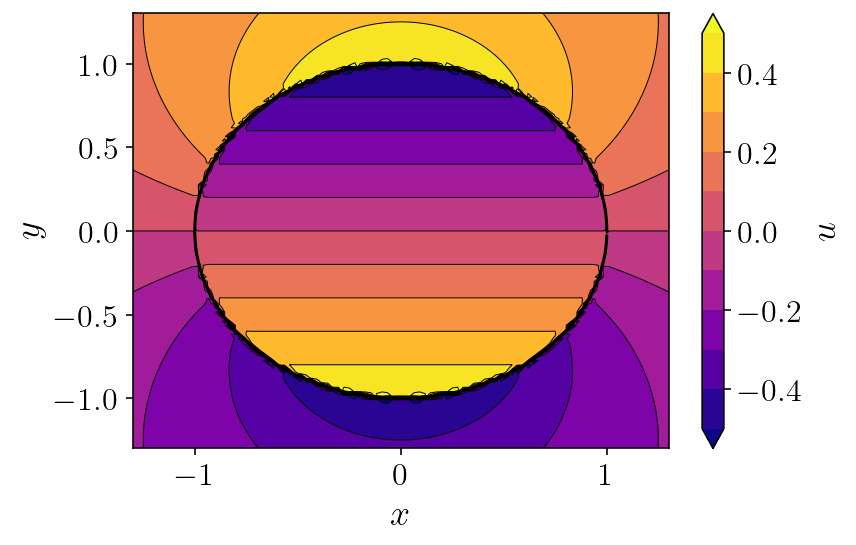

In [11]:
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
cntf = plt.contourf(xs, ys, u, levels=np.linspace(-0.5, 0.5, 11), extend="both")
plt.contour(
    xs,
    ys,
    u,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.5, 0.5, 11),
    extend="both",
)
cbar = plt.colorbar(cntf)
plt.xlabel('$x$')
plt.ylabel('$y$')
cbar.set_label('$u$')
plt.show()

Pretty picture! But, you can immediately see the uglyness near the boundary! This is what we'll solve with QBX. Let's actually quantify that error. We'll compare our 200 point integration against a 2000 point integration.

In [12]:
zoomnobs = 400
zoomx = [0.75, 1.25]
zoomy = [0.15, 0.65]
zoomxs = np.linspace(*zoomx, zoomnobs)
zoomys = np.linspace(*zoomy, zoomnobs)
zoomobs_pts = pts_grid(zoomxs, zoomys)

zoomu_low = (
    double_layer_matrix(surface_low, zoomobs_pts)
    .dot(surface_low.pts[:,1])
    .reshape((zoomnobs, zoomnobs))
)

surface_high = circle(2000)
zoomu_high = (
    double_layer_matrix(surface_high, zoomobs_pts)
    .dot(surface_high.pts[:,1])
    .reshape((zoomnobs, zoomnobs))
)

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_84115/4222150689.py:48: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(zoomu_low - zoomu_high))


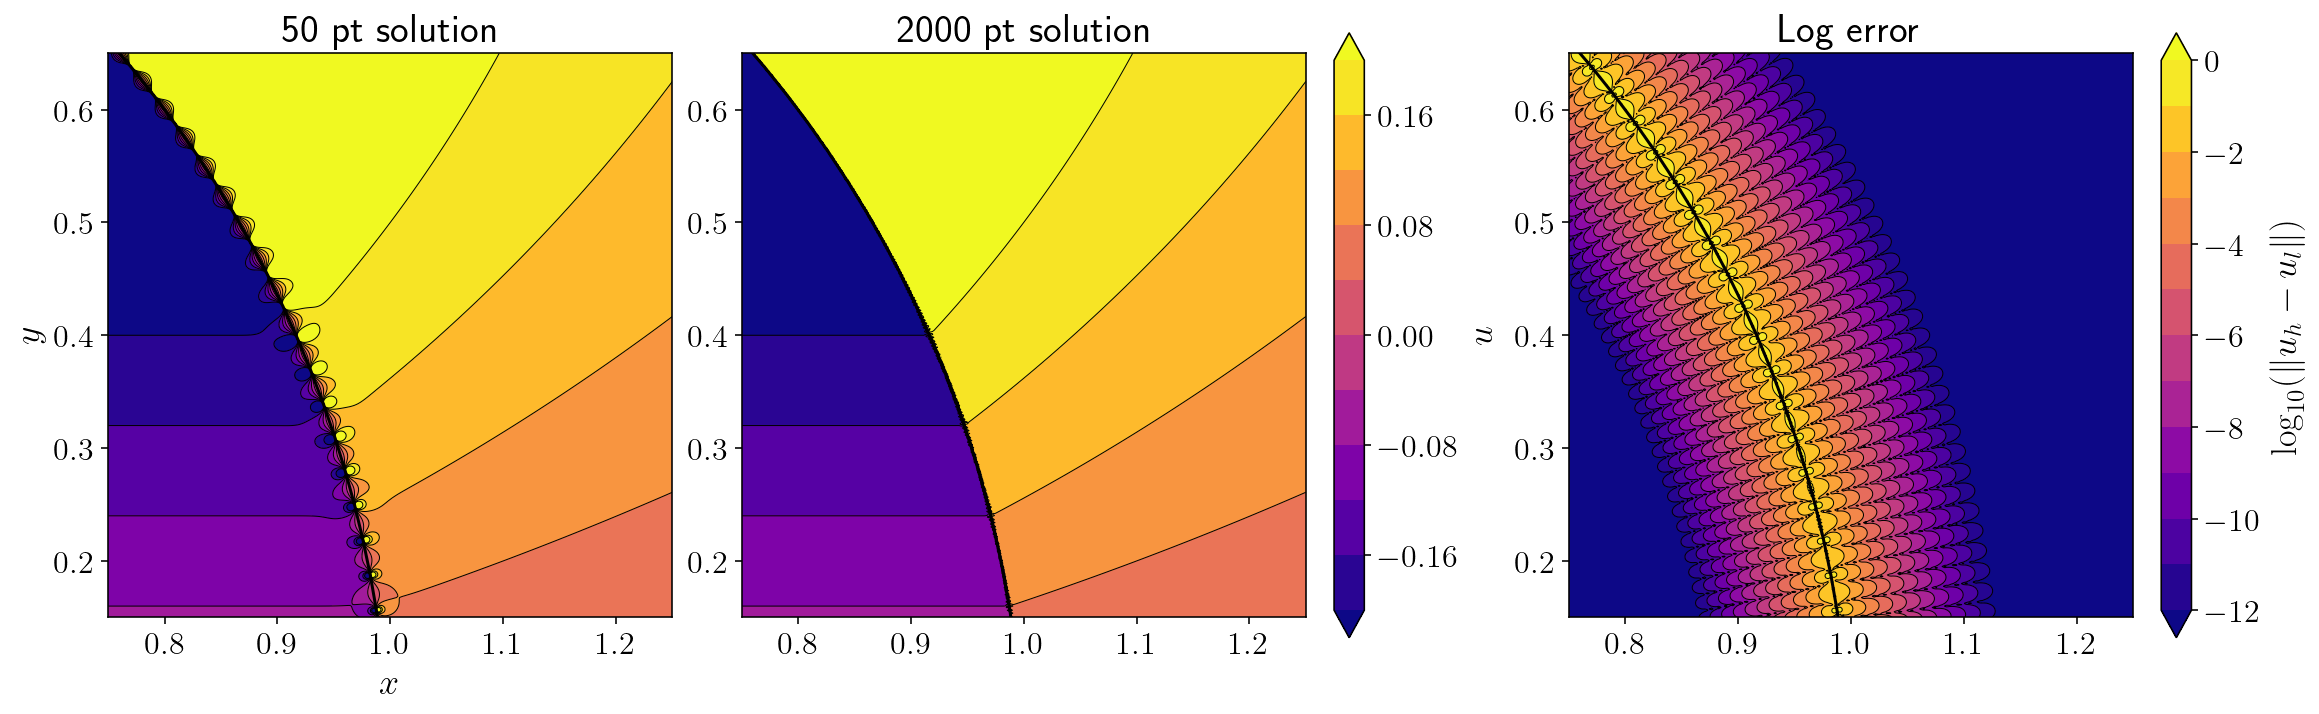

In [13]:
plt.figure(figsize=(16, 5), constrained_layout=True)
plt.subplot(1, 3, 1)
plt.title('50 pt solution')
cntf = plt.contourf(
    zoomxs, zoomys, zoomu_low, levels=np.linspace(-0.2, 0.2, 11), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    zoomu_low,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.2, 0.2, 11),
    extend="both",
)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.axis('scaled')
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.subplot(1, 3, 2)
plt.title('2000 pt solution')
cntf = plt.contourf(
    zoomxs, zoomys, zoomu_high, levels=np.linspace(-0.2, 0.2, 11), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    zoomu_high,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.2, 0.2, 11),
    extend="both",
)
cbar = plt.colorbar(cntf)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.axis('scaled')
plt.xlim(zoomx)
plt.ylim(zoomy)
cbar.set_label('$u$')

plt.subplot(1, 3, 3)
plt.title('Log error')
logerror = np.log10(np.abs(zoomu_low - zoomu_high))
logerror[np.isinf(logerror)] = -12.0
cntf = plt.contourf(
    zoomxs, zoomys, logerror, levels=np.linspace(-12, 0, 13), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-12, 0, 13),
    extend="both",
)
cbar = plt.colorbar(cntf)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
cbar.set_label("$\log_{10}(\|u_h - u_l\|)$")
plt.axis('scaled')
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

We're zoomed in on the upper right edge of the circle here. You can see the little dipoles from the low order quadrature on the left. In the middle, the super high order quadrature cleans up the picture. The right hand figure shows the $\log_{10}$ error in the low order integrals. The error very close to the surface is more-or-less 100%. There are two important take-aways here: 
1. The number of quadrature points required for accurate direct quadrature scales inversely with the distance of the observation point to the source surface. In the figure above, if you zoomed in by a factor of 10x, you'd see the dipoles again even with the 2000 point quadrature. This isn't actually too bad. Most of the time we don't need to compute integrals super close to the source surface and if we do, adaptive quadrature has been efficient enough for most applications I've worked on. 
2. The real problem is that we **often need to compute integrals where the observation point lies directly on the source surface**. If the number of quadrature points required for an accurate integral is scaling inversely with the distance from the source surface, a naive extrapolation implies that an *infinite number of quadrature points* will be required to accurately evaluate the integral for an observation point on the source surface. This is where QBX is going to save the day.

### Accurate near-field evaluation

Let's try again with the low-order quadrature rule but this time using QBX! We're going to use a tenth order expansion offset from the source surface by about 0.2.

In [14]:
qbx_p = 10
qbx_r = 0.20
qbx_center_x = surface_low.pts[14,0] * (1 + qbx_r)
qbx_center_y = surface_low.pts[14,1] * (1 + qbx_r)
qbx_center_x, qbx_center_y

(1.0857924629592233, 0.5109351498780872)

So, we now need to compute the circular integrals for the coefficients. A rule of thumb is to use a trapezoidal rule with $2p$ points.

In [15]:
trap_x, trap_weights = trapezoidal_rule(2 * qbx_p)

# transform the quadrature rule from [-1, 1] to [0, 2*pi]
trap_theta = np.pi * (trap_x + 1)
# multiply the quadrature weights by the jacobian of the transformation
trap_weights *= np.pi

Our expansion center is approximately a distance of 0.5 from the boundary, so our coefficient integrals are computed a distance of 0.25 from the expansion center (remember $\delta = 1/2$).

In [16]:
qbx_delta_r = qbx_r * 0.5
# (qbx_x, qbx_y) defines the points used for computing the circular coefficient integrals centered at the expansion center.
qbx_x = qbx_delta_r * np.cos(trap_theta) + qbx_center_x
qbx_y = qbx_delta_r * np.sin(trap_theta) + qbx_center_y

Now, we need the value of $u(x)$ at the points `(qbx_x, qbx_y)`.

In [17]:
qbx_xy = np.hstack((qbx_x[:,None], qbx_y[:,None]))
qbx_u = double_layer_matrix(surface_low, qbx_xy).dot(phi)

And here we implement the coefficient integrals. This looks ugly, but it's a direct implementation of the discretized coefficient integrals where $\omega_i$ are the quadrature weights `trap_ws`

$$\alpha_l = \frac{1}{\pi (\delta r)^l}\sum_{i=0}^{2p} \omega_i u(\mathbf{c} + \delta r(cos \theta_i, sin \theta_i)) e^{-il\theta_i} $$

In [18]:
alpha = []
for L in range(qbx_p):
    C = 1.0 / (np.pi * (qbx_delta_r ** L))
    if L == 0:
        C /= 2.0
    alpha.append(C * np.sum(trap_weights * qbx_u * np.exp(-1j * L * trap_theta)))

We convert the expansion center and the observation points to be complex.

In [19]:
zoom_complex = (zoomobs_pts[:,0] + zoomobs_pts[:,1] * 1j).reshape((zoomnobs, zoomnobs))
qbx_center = qbx_center_x + qbx_center_y * 1j

And finally, evaluate the expansion in complex space:

In [20]:
zoomu_qbx = np.zeros_like(zoomu_low)
for L in range(qbx_p):
    zoomu_qbx += np.real(alpha[L] * ((zoom_complex - qbx_center) ** L))

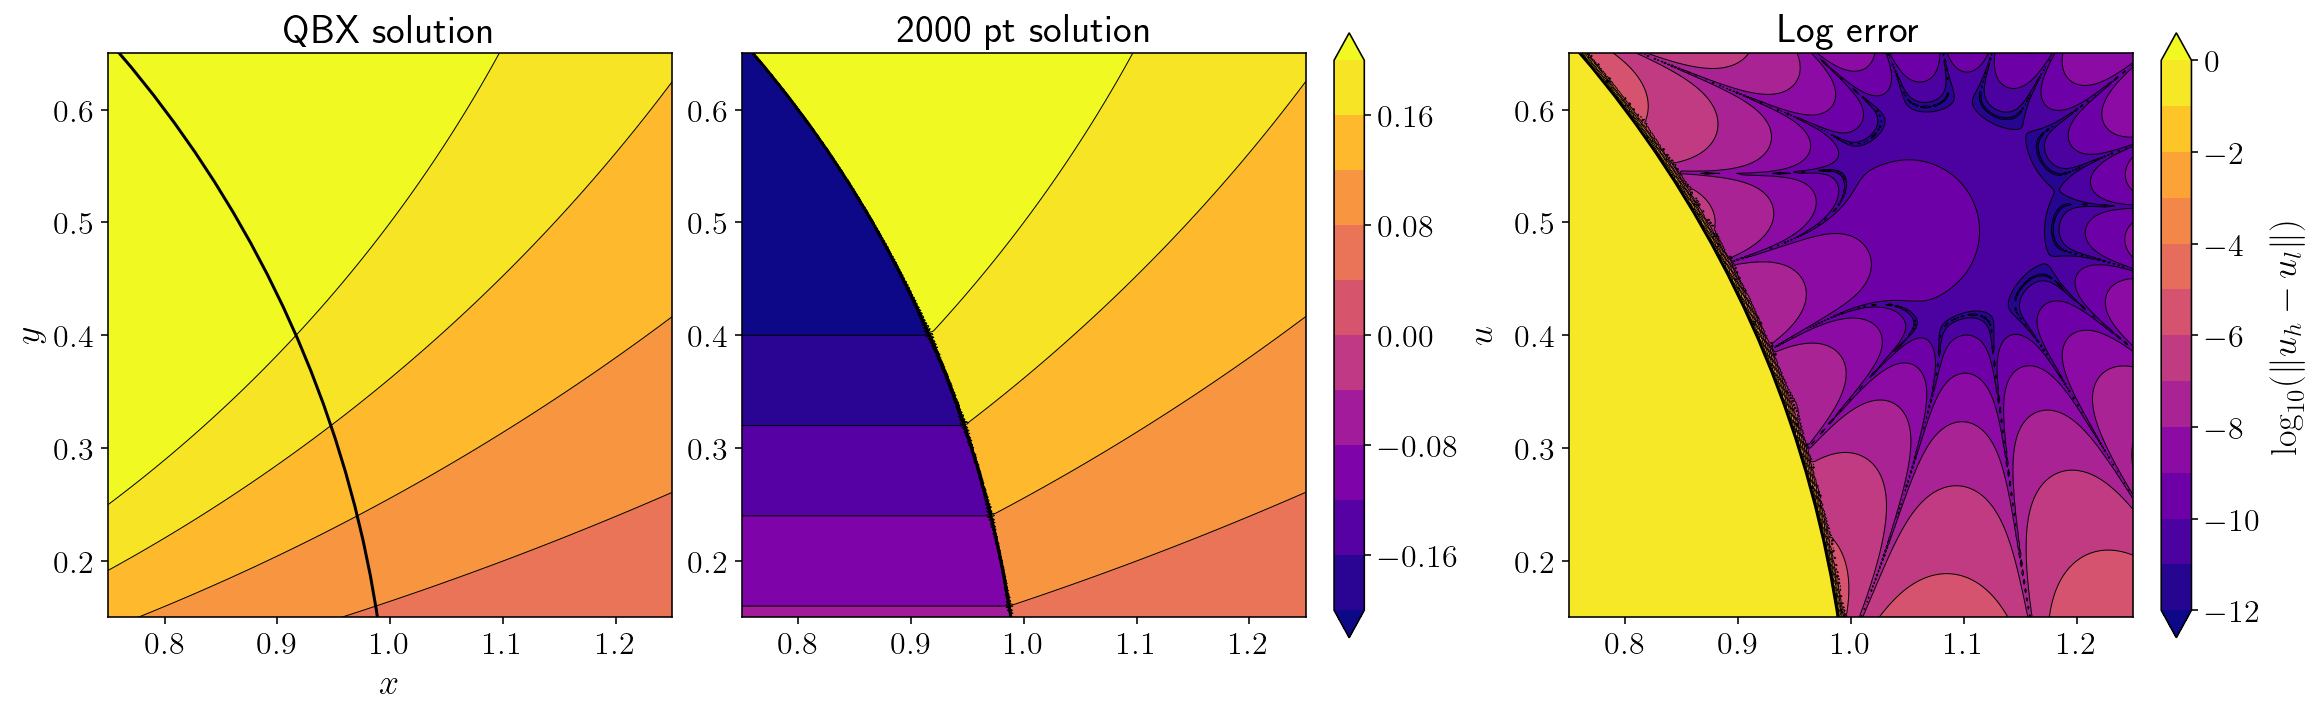

In [21]:
plt.figure(figsize=(16, 5), constrained_layout=True)
plt.subplot(1, 3, 1)
plt.title('QBX solution')
cntf = plt.contourf(
    zoomxs, zoomys, zoomu_qbx, levels=np.linspace(-0.2, 0.2, 11), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    zoomu_qbx,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.2, 0.2, 11),
    extend="both",
)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.axis('scaled')
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.subplot(1, 3, 2)
plt.title('2000 pt solution')
cntf = plt.contourf(
    zoomxs, zoomys, zoomu_high, levels=np.linspace(-0.2, 0.2, 11), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    zoomu_high,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.2, 0.2, 11),
    extend="both",
)
cbar = plt.colorbar(cntf)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.axis('scaled')
plt.xlim(zoomx)
plt.ylim(zoomy)
cbar.set_label('$u$')

plt.subplot(1, 3, 3)
plt.title('Log error')
logerror = np.log10(np.abs(zoomu_qbx - zoomu_high))
logerror[np.isinf(logerror)] = -12.0
cntf = plt.contourf(
    zoomxs, zoomys, logerror, levels=np.linspace(-12, 0, 13), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-12, 0, 13),
    extend="both",
)
cbar = plt.colorbar(cntf)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
cbar.set_label("$\log_{10}(\|u_h - u_l\|)$")
plt.axis('scaled')
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

The left panel here shows $u(x)$ from the QBX evaluation, the middle panel shows $u(x)$ from the 2000 point quadrature and the right panel shows the $\log_{10}$ error in the QBX evaluation. Take-aways:
* The error near the portion of the surface closest to the expansion center is now quite good. We're succesfully doing an accurate near-field evaluation despite using a small number of source quadrature points!
* Points far away from the expansion center are less accurate.
* The QBX expansion is entirely wrong interior to the circle on the other side of the surface. This is entirely expected since there is a jump in $u(x)$ across the surface and a step function like that would be impossible to approximate with a power series.

## General-purpose QBX implementation

While what we did so far is a cool demonstration, it's not a practical implementation. Ultimately, we need to be able to provide a big list of observation points and expect the code to choose whether to compute the integral directly or, if a point is near the surface, use QBX. And, we need to assign observation points to which expansion they are going to use. To do this, we will use the `tectosaur2.integrate_term` function which:
1. Constructs a far-field matrix for the observation points and source points which are not very close to each other. These matrix entries are computed directly without QBX.
2. Identifies those observation points that needed to handled more carefully because they are near some portion of the source surface. These are split into nearfield observation points that will be handled with a simple adaptive quadrature function and QBX observation points that will use expansions for evaluation.
3. Identifies the optimal expansion center for each QBX observation point and computes QBX matrix entries. The expansion order is adaptively chosen to satisfy the tolerance specified by the `tol` parameter. Adaptive quadrature is used to accurately compute the expansion coefficients. 
4. Performs adaptive quadrature for the nearfield observation points. 
5. Combines the farfield, nearfield and QBX matrix components together to construct the matrix representing the discrete integral operator.

The main three parameters for the `integrate_term` function are:
1. The integral kernel. In this case, the double layer kernel.
2. The observation points.
3. The source surface. 

Below, we'll use this function to calculate an extremely accurate solution:

In [22]:
from tectosaur2 import integrate_term, unit_circle, gauss_rule
from tectosaur2.laplace2d import double_layer
circle_tct = unit_circle(gauss_rule(10), max_curvature=0.5)
bie_mat = integrate_term(double_layer, zoomobs_pts, circle_tct, tol=1e-12)
zoomu_full_qbx = bie_mat[:,0,:,0].dot(circle_tct.pts[:,1]).reshape((zoomnobs, zoomnobs))

Integration failed for observation point (0.970551, 0.241479) , source panel center at: (0.974664, 0.223673), panel_idx: 8, n_integrals: 100
Expansion center: (0.970461, 0.241458) with expansion radius: 9.23206e-05
The maximum estimated coefficient error: 1.48629e-09 with tolerance: 1e-12


/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:201: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(


We'll also create a second solution where we use just a single QBX center with index 14. We'll use the make-shift we calculated in the previous section to do this. Having this single expansion solution is just a nice comparison. Doing this will also demonstrate one of the complexities in a full solution: deciding when to use QBX and when to use a direct evaluation.

In [23]:
# For most of the observation points, we'll use the direct quadrature.
zoomu_qbx14 = zoomu_low.copy().flatten()

# When should we use QBX? When an observation point is close to the expansion
# center and also close to the source surface.
dist_to_exp_center = np.sqrt(
    (zoomobs_pts[:, 0] - qbx_center_x) ** 2 + (zoomobs_pts[:, 1] - qbx_center_y) ** 2
)
dist_to_src_surface = np.abs(np.sqrt(zoomobs_pts[:, 0] ** 2 + zoomobs_pts[:, 1] ** 2) - 1)
use_qbx = (dist_to_exp_center < qbx_r) & (dist_to_src_surface < qbx_r)

# Compute the QBX solution when use_qbx is True
use_qbx_complex = zoomobs_pts[use_qbx, 0] + zoomobs_pts[use_qbx, 1] * 1j
zoomu_qbx14[use_qbx] = 0
for L in range(qbx_p):
    zoomu_qbx14[use_qbx] += np.real(alpha[L] * ((use_qbx_complex - qbx_center) ** L))
zoomu_qbx14 = zoomu_qbx14.reshape((zoomnobs, zoomnobs))

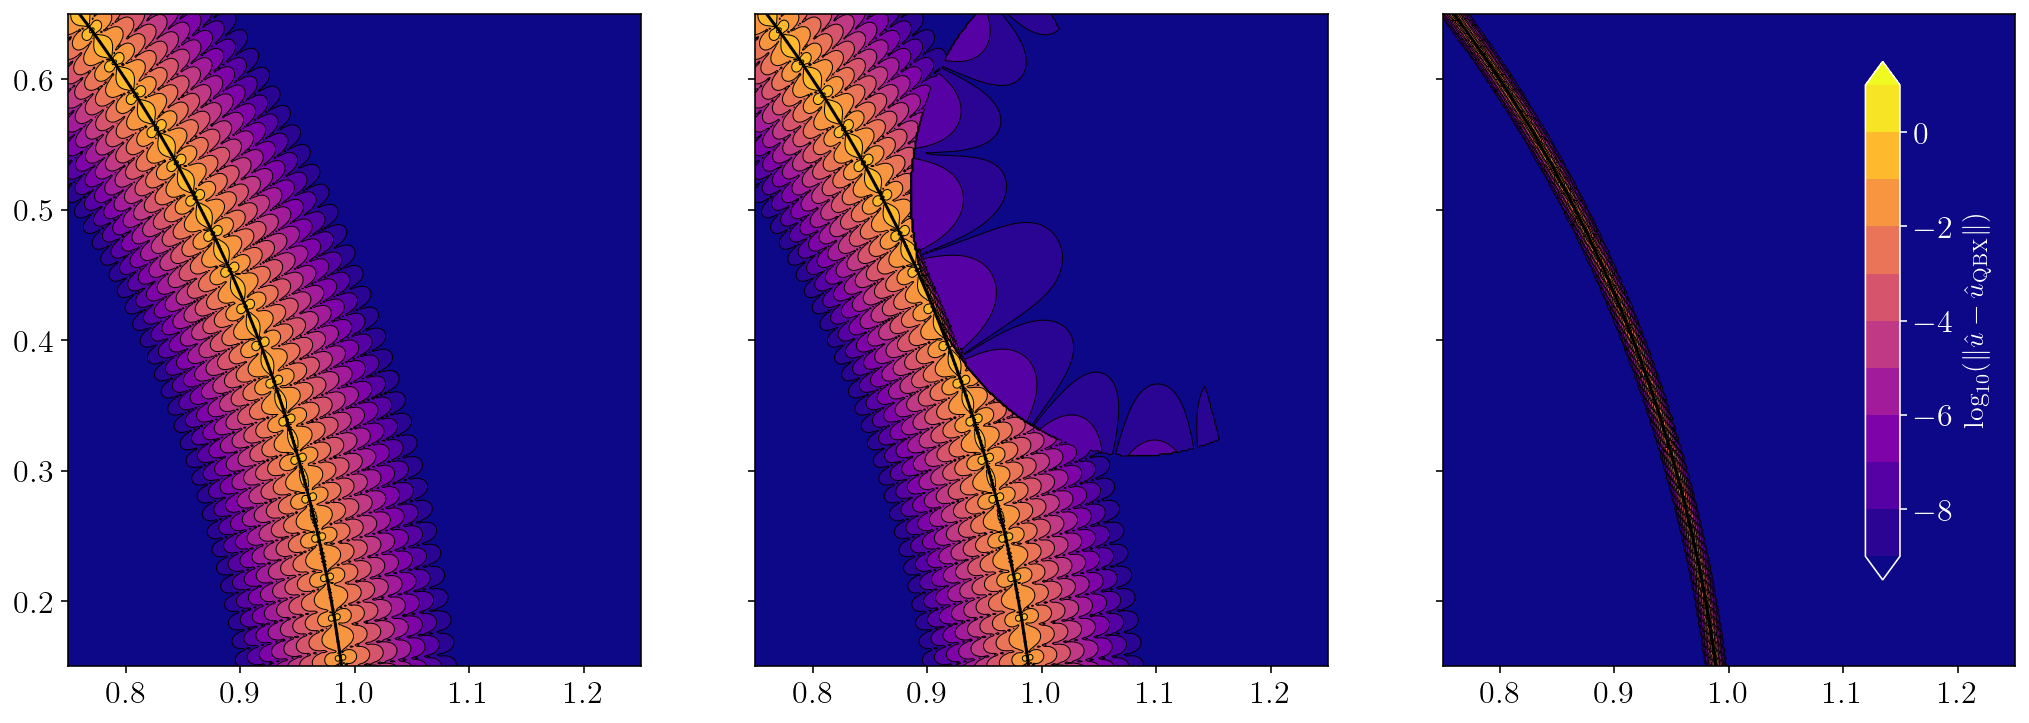

In [24]:
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["axes.facecolor"] = (1.0, 1.0, 1.0, 0.0)
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 0.0)
plt.rcParams["savefig.facecolor"] = (1.0, 1.0, 1.0, 0.0)
plt.rcParams["savefig.transparent"] = False

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), constrained_layout=True)

plt.subplot(1, 3, 1)
logerror = np.log10(np.abs(zoomu_high - zoomu_low))
logerror[np.isinf(logerror)] = -17.0
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
error_levels = np.linspace(-9, 1, 11)
cntf = plt.contourf(zoomxs, zoomys, logerror, levels=error_levels, extend="both")
plt.contour(
    zoomxs,
    zoomys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()

plt.subplot(1, 3, 2)
logerror = np.log10(np.abs(zoomu_high - zoomu_qbx14))
logerror[np.isinf(logerror)] = -17.0
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
cntf = plt.contourf(zoomxs, zoomys, logerror, levels=error_levels, extend="both")
plt.contour(
    zoomxs,
    zoomys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])

plt.subplot(1, 3, 3)
logerror = np.log10(np.abs(zoomu_high - zoomu_full_qbx))
logerror[np.isinf(logerror)] = -17.0
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
cntf = plt.contourf(zoomxs, zoomys, logerror, levels=error_levels, extend="both")
plt.contour(
    zoomxs,
    zoomys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])

fig.subplots_adjust(right=0.97)
cbar_ax = fig.add_axes([0.905, 0.225, 0.015, 0.6])
cbar_ax.patch.set_alpha(0.0)
cb = fig.colorbar(cntf, cax=cbar_ax)

cb.set_label(
    "$\log_{10}(\|\hat{u} - \hat{u}_{\\textrm{QBX}}\|)$", color="w", fontsize=14
)
cb.ax.yaxis.set_tick_params(color="w")
cb.outline.set_edgecolor("w")
cbytick_obj = plt.getp(cb.ax.axes, "yticklabels")
plt.setp(cbytick_obj, color="w")

plt.show()


```{margin}
Below, we tested QBX against an adaptive quadrature computation. They match to 13 digits. Why don't we use this adaptive quadrature approach all the time? The answer is that it's very slow and it won't work at all if the observation point is precisely on the source surface.
```

The left figure shows the $\log_{10}$ error for a naive brute-force integration. The middle figure shows the $\log_{10}$ error when we use a single QBX expansion center. The right figure shows the $\log_{10}$ when we use the closest QBX expansion center for every exterior point close to the boundary.
We can see some remaining error right near the source surface. This remaining error is actually entirely from the 2000 direct quadrature side. To prove that, I'll compare the QBX solution for the point with the worst error against an adaptively integrated solution. I think this is a nice way to finish up because it demonstrates how QBX is efficiently computing an integral to machine precision in a situation where even a 2000 point quadrature rule is suffering over 100% error. 

In [25]:
# Find the index of the point with the highest log error.
worst_idx = np.argmax(logerror)
ox, oy = zoomobs_pts[worst_idx]

def f(t):
    sx = np.cos(t)
    sy = np.sin(t)
    r2 = (ox - sx) ** 2 + (oy - sy) ** 2
    kernel = ((ox - sx) * sx + (oy - sy) * sy) / (2 * np.pi * r2)
    phi = sy
    return phi * kernel

import scipy.integrate
adaptive_soln = scipy.integrate.quad(f, 0, 2*np.pi, epsabs=1e-12, epsrel=1e-12)
print('The QBX solution is', zoomu_full_qbx.ravel()[worst_idx])
print('The 2000 point solution is', zoomu_high.ravel()[worst_idx])
print('The QBX error is', adaptive_soln[0] - zoomu_full_qbx.ravel()[worst_idx])
print('The 2000 point quadrature error is', adaptive_soln[0] - zoomu_high.ravel()[worst_idx])

The QBX solution is 0.26919570868980797
The 2000 point solution is 2.3843894039954843
The QBX error is 5.69266855876549e-13
The 2000 point quadrature error is -2.115193695305107


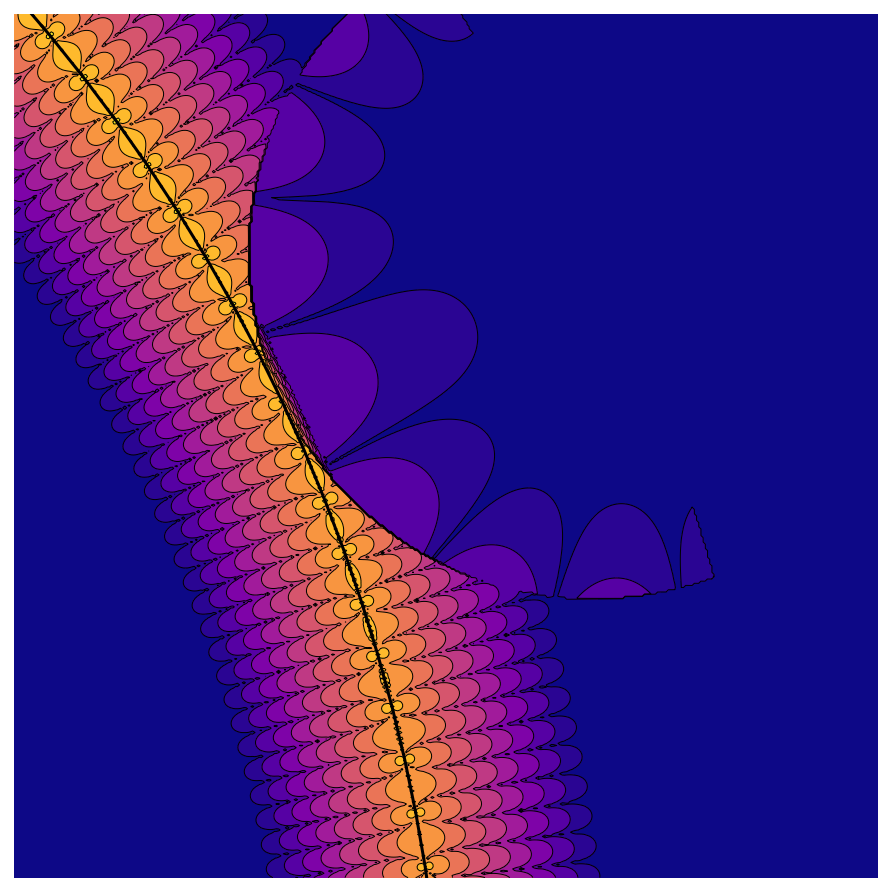

In [26]:
# REMOVED_CELL_ALERT
logerror = np.log10(np.abs(zoomu_high - zoomu_qbx14))
logerror[np.isinf(logerror)] = -17.0
start_idx = 1
end_idx = 50
plt.figure(figsize=(6, 6), facecolor=(1.0, 1.0, 1.0, 0.0))
plt.plot(surface_low.pts[1:50,0], surface_low.pts[1:50,1], "k-", linewidth=1.5)
cntf = plt.contourf(zoomxs, zoomys, logerror, levels=error_levels, extend="both")
plt.contour(
    zoomxs,
    zoomys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
ax.set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
plt.savefig("qbx_single.svg", box_inches="tight", pad_inches=0, transparent=True)
plt.show()